In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

NameError: name 'agg' is not defined

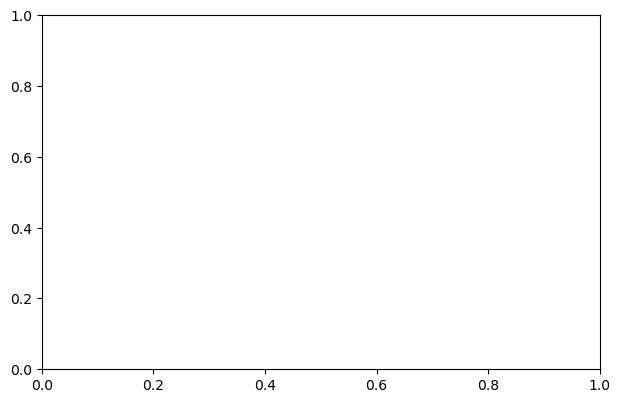

In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장)
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 샘플 데이터 (agg 미정의 시 생성) =====
if 'agg' not in globals():
    np.random.seed(0)
    sample_algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    noise_levels = np.arange(0, 60, 10)
    rows = []
    for algo in sample_algos:
        mean = 1.0 + 0.5 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high = mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 기본 스타일/순서 세팅 =====
order = agg["algorithm"].unique().tolist()
palette = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 =====
fig, ax = plt.subplots(figsize=(7.2, 4.6))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo]
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["noise"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["noise"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 라벨 위치 계산을 위해 마지막 점 저장
    x_last = float(tmp["noise"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축 설정 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
x_min, x_max = float(agg["noise"].min()), float(agg["noise"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max + 12)

ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 라벨링 =====
end_points.sort(key=lambda t: t[2])
yrange = y_max - y_min
xpad = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min+0.01*yrange, y_max-0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 충돌 방지
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))

for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(
        x_last + xpad, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-bosun", exist_ok=True)
out_png = "figs-bosun/exp1_cr_vs_noise_endlabels.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved: {out_png}")
